In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()
    def render_np(self):
        displ_board = np.zeros(( 4,  4), dtype = np.uint8)
        displ_board[self.board.components['Player'].pos] = 1
        displ_board[self.board.components['Goal'].pos] = 2
        displ_board[self.board.components['Pit'].pos] = 3
        displ_board[self.board.components['Wall'].pos] = 4
        return displ_board

In [3]:
game = Gridworld(size=4, mode='static')
game.render_np()

array([[2, 3, 0, 1],
       [0, 4, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [4]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [19]:
def test_model(model,mode='static', display=True):
    i = 0
    w, h = 8, 100
    matrix = [[0 for x in range(w)] for y in range(h)] 
    test_game = Gridworld(mode=mode)
    state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    counter = 0
    while(status == 1): #A
        matrix[counter][0] = (str(test_game.board.components['Player'].pos))
        matrix[counter][5] = (str(test_game.board.components['Pit'].pos))
        matrix[counter][6] = (str(test_game.board.components['Goal'].pos))
        matrix[counter][7] = (str(test_game.board.components['Wall'].pos))
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        matrix[counter][2] = action 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action, counter)
        matrix[counter][1] = (str(test_game.board.components['Player'].pos))
        state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        matrix[counter][3] = reward
        matrix[counter][4] = i
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        counter = counter + 1 
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

D:\Conda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Games played: 1000, # of wins: 1000
Win percentage: 100.0%


Text(0, 0.5, 'Loss')

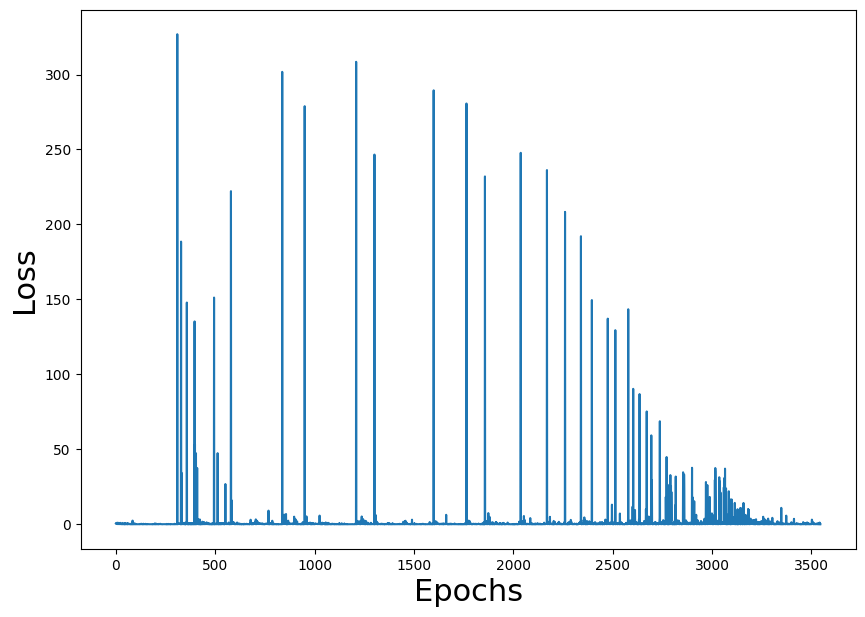

In [6]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
l1 = 16
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

epochs = 150
losses = [] #A
w, h = 23, 100000
matrix = [[0 for x in range(w)] for y in range(h)] 
counter = 0
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        matrix[counter][5] = epsilon 
        matrix[counter][0] = i + 1
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][11] = (str(game.board.components['Pit'].pos))
        matrix[counter][12] = (str(game.board.components['Goal'].pos))
        matrix[counter][13] = (str(game.board.components['Wall'].pos))

        qval = model(state1) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            matrix[counter][4] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][4] = 0 
            action_ = np.argmax(qval_)
        action = action_set[action_] #J
        matrix[counter][6] = action_
        matrix[counter][14] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][15] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][16] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][17] = round(list(model.parameters())[5][0].item(),6)
        game.makeMove(action) #K
        state2_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,16))
        maxQ = torch.max(newQ) #M
        matrix[counter][8] = maxQ.item()
        if reward == -1: #N
            matrix[counter][3] = -1 
            Y = reward + (gamma * maxQ)
        else:
            matrix[counter][3] = reward 
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        

        matrix[counter][7] = X.item()
        matrix[counter][9] = Y.item()
        loss = loss_fn(X, Y) #P
        matrix[counter][10] = loss.item()
#             print(i, loss.item())
#             clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        matrix[counter][2] = (str(game.board.components['Player'].pos))
        matrix[counter][18] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][19] = round(list(model.parameters())[5][1].item(),6)
        matrix[counter][20] = round(list(model.parameters())[5][2].item(),6)
        matrix[counter][21] = round(list(model.parameters())[5][3].item(),6)
        matrix[counter][22] = counter + 1

        counter = counter + 1 
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='static', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [7]:
import pandas as pd
column_names = ["Epochs","Current_State", "Next_State", "Reward","Epsilon_Boolean", "Epsilon", "Action",
                "Current_Q_Value", "Next_Q_Value","Reawrd_Plus_Next_Q_Value", "Loss",
                "Pit_Position", "Goal_Position", "Wall_Position",
                "CurWeight[0]", "CurWeight[1]", "CurWeight[2]", "CurWeight[3]",
                "NextWeight[0]","NextWeight[1]","NextWeight[2]","NextWeight[3]", "Step" 
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
# mapping = {"Epochs":"Epochs","Next_State":"Next_State","Reward":"Reward","Cuttent_State":"Cuttent_State",
#            "Epsilon_Boolean":"Epsilon_Boolean","Epsilon":"Epsilon",
#            "Action":"Action", "Current_Q_Value":"Current_Q_Value",
#            "Next_Q_Value":"Next_Q_Value", "Reawrd_Plus_Next_Q_Value":"Reawrd_Plus_Next_Q_Value",
#            "Loss":"Loss","Pit_Position":"Pit_Position", "Goal_Position": "Goal_Position",
#            "Wall_Position":"Wall_Position",
#            'Model_Param_Current[0]': 'Current_Model_Parameters', 'Model_Param_Current[1]': 'Current_Model_Parameters',
#            'Model_Param_Current[2]': 'Current_Model_Parameters', 'Model_Param_Current[3]': 'Current_Model_Parameters',
#            'Model_Param_Next[0]': 'Next_Model_Parameters', 'Model_Param_Next[1]': 'Next_Model_Parameters',
#            'Model_Param_Next[2]': 'Next_Model_Parameters', 'Model_Param_Next[3]': 'Next_Model_Parameters',   
#           }
# df = df.set_index('Step').groupby(mapping, axis = 1).sum()
  
# df.reset_index(level = 0)
sliced_df = pd.concat([df.head(10), df.tail(10)])
sliced_df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,...,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
0,1,"(0, 3)","(0, 3)",-1,1,1.0,0,-0.008759,0.296021,-0.733581,...,"(1, 1)",-0.087626,-0.087626,-0.087626,-0.087626,-0.088626,-0.081253,0.030122,-0.002207,1
1,1,"(0, 3)","(0, 2)",-1,1,1.0,2,-0.108034,0.248714,-0.776157,...,"(1, 1)",-0.088626,-0.088626,-0.088626,-0.088626,-0.089296,-0.081253,0.029378,-0.002207,2
2,1,"(0, 2)","(1, 2)",-1,1,1.0,1,-0.016561,0.265902,-0.760688,...,"(1, 1)",-0.089296,-0.089296,-0.089296,-0.089296,-0.089814,-0.081891,0.028803,-0.002207,3
3,1,"(1, 2)","(1, 2)",-1,1,1.0,2,-0.167732,0.266360,-0.760276,...,"(1, 1)",-0.089814,-0.089814,-0.089814,-0.089814,-0.090238,-0.082415,0.028065,-0.002207,4
4,1,"(1, 2)","(0, 2)",-1,1,1.0,0,-0.374472,0.257668,-0.768099,...,"(1, 1)",-0.090238,-0.090238,-0.090238,-0.090238,-0.090814,-0.082857,0.027441,-0.002207,5
5,1,"(0, 2)","(0, 2)",-1,1,1.0,0,-0.334346,0.256109,-0.769502,...,"(1, 1)",-0.090814,-0.090814,-0.090814,-0.090814,-0.091496,-0.083238,0.026903,-0.002207,6
6,1,"(0, 2)","(0, 3)",-1,1,1.0,3,0.254803,0.291489,-0.737660,...,"(1, 1)",-0.091496,-0.091496,-0.091496,-0.091496,-0.092093,-0.083571,0.026433,-0.002714,7
7,1,"(0, 3)","(1, 3)",-1,1,1.0,1,-0.253090,0.236057,-0.787549,...,"(1, 1)",-0.092093,-0.092093,-0.092093,-0.092093,-0.092618,-0.084099,0.026019,-0.003160,8
8,1,"(1, 3)","(1, 2)",-1,1,1.0,2,-0.404552,0.195048,-0.824457,...,"(1, 1)",-0.092618,-0.092618,-0.092618,-0.092618,-0.093085,-0.084567,0.025479,-0.003556,9
9,1,"(1, 2)","(0, 2)",-1,1,1.0,0,-0.603132,0.128054,-0.884752,...,"(1, 1)",-0.093085,-0.093085,-0.093085,-0.093085,-0.093624,-0.084986,0.024996,-0.003910,10


Text(0, 0.5, 'Loss')

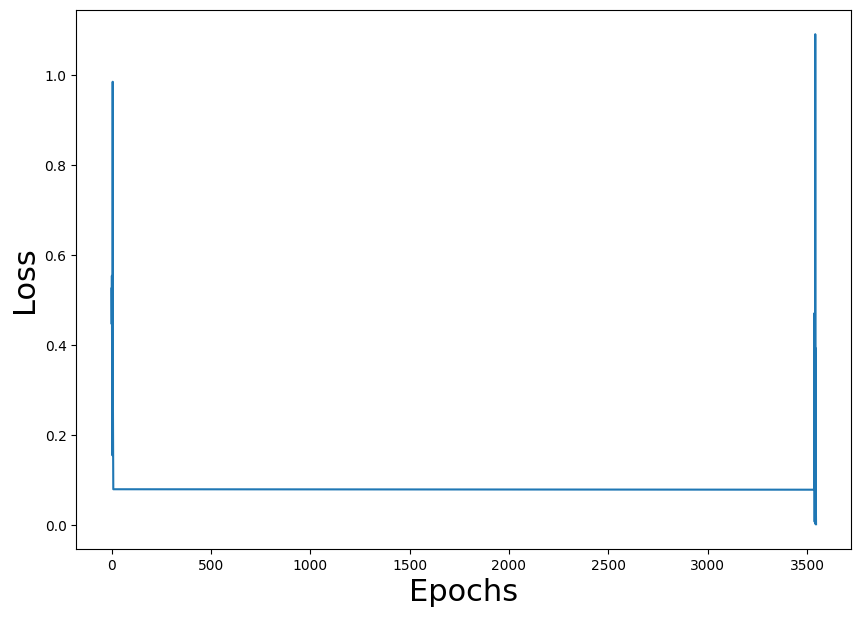

In [8]:
plt.figure(figsize=(10,7))
plt.plot(sliced_df["Loss"])
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [9]:
df['Current_State'] = df['Current_State'].replace(['(0, 0)'],0)
df['Current_State'] = df['Current_State'].replace(['(0, 1)'],1)
df['Current_State'] = df['Current_State'].replace(['(0, 2)'],2)
df['Current_State'] = df['Current_State'].replace(['(0, 3)'],3)
df['Current_State'] = df['Current_State'].replace(['(1, 0)'],4)
df['Current_State'] = df['Current_State'].replace(['(1, 1)'],5)
df['Current_State'] = df['Current_State'].replace(['(1, 2)'],6)
df['Current_State'] = df['Current_State'].replace(['(1, 3)'],7)
df['Current_State'] = df['Current_State'].replace(['(2, 0)'],8)
df['Current_State'] = df['Current_State'].replace(['(2, 1)'],9)
df['Current_State'] = df['Current_State'].replace(['(2, 2)'],10)
df['Current_State'] = df['Current_State'].replace(['(2, 3)'],11)
df['Current_State'] = df['Current_State'].replace(['(3, 0)'],12)
df['Current_State'] = df['Current_State'].replace(['(3, 1)'],13)
df['Current_State'] = df['Current_State'].replace(['(3, 2)'],14)
df['Current_State'] = df['Current_State'].replace(['(3, 3)'],15)
df['Next_State'] = df['Next_State'].replace(['(0, 0)'],0)
df['Next_State'] = df['Next_State'].replace(['(0, 1)'],1)
df['Next_State'] = df['Next_State'].replace(['(0, 2)'],2)
df['Next_State'] = df['Next_State'].replace(['(0, 3)'],3)
df['Next_State'] = df['Next_State'].replace(['(1, 0)'],4)
df['Next_State'] = df['Next_State'].replace(['(1, 1)'],5)
df['Next_State'] = df['Next_State'].replace(['(1, 2)'],6)
df['Next_State'] = df['Next_State'].replace(['(1, 3)'],7)
df['Next_State'] = df['Next_State'].replace(['(2, 0)'],8)
df['Next_State'] = df['Next_State'].replace(['(2, 1)'],9)
df['Next_State'] = df['Next_State'].replace(['(2, 2)'],10)
df['Next_State'] = df['Next_State'].replace(['(2, 3)'],11)
df['Next_State'] = df['Next_State'].replace(['(3, 0)'],12)
df['Next_State'] = df['Next_State'].replace(['(3, 1)'],13)
df['Next_State'] = df['Next_State'].replace(['(3, 2)'],14)
df['Next_State'] = df['Next_State'].replace(['(3, 3)'],15)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 0)'],0)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 1)'],1)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 1)'],5)

In [10]:
df = df[df["Epochs"] > 130]
df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,...,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
3381,131,3,3,-1,1,0.133333,0,-0.766606,0.382587,-0.655672,...,5,-0.037730,-0.037730,-0.037730,-0.037730,-0.037654,-0.108119,0.096861,-0.030044,3382
3382,131,3,3,-1,1,0.133333,3,0.136473,0.760973,-0.315125,...,5,-0.037654,-0.037654,-0.037654,-0.037654,-0.037586,-0.108234,0.096841,-0.030133,3383
3383,131,3,7,-1,0,0.133333,1,0.754636,1.951047,0.755942,...,5,-0.037586,-0.037586,-0.037586,-0.037586,-0.037525,-0.108336,0.096822,-0.030213,3384
3384,131,7,11,-1,0,0.133333,1,1.962322,3.935995,2.542396,...,5,-0.037525,-0.037525,-0.037525,-0.037525,-0.037469,-0.108273,0.096805,-0.030285,3385
3385,131,11,10,-1,0,0.133333,2,3.960440,5.001873,3.501685,...,5,-0.037469,-0.037469,-0.037469,-0.037469,-0.037419,-0.108216,0.096735,-0.030350,3386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,150,12,8,-1,0,0.100000,0,7.244501,8.000181,6.200163,...,5,-0.038594,-0.038594,-0.038594,-0.038594,-0.038676,-0.102693,0.097779,-0.034512,3542
3542,150,8,4,-1,1,0.100000,0,7.945160,10.141031,8.126928,...,5,-0.038676,-0.038676,-0.038676,-0.038676,-0.038732,-0.102785,0.097739,-0.034516,3543
3543,150,4,8,-1,1,0.100000,1,6.661772,7.816794,6.035115,...,5,-0.038732,-0.038732,-0.038732,-0.038732,-0.038783,-0.103041,0.097703,-0.034520,3544
3544,150,8,4,-1,0,0.100000,0,7.773658,9.988299,7.989470,...,5,-0.038783,-0.038783,-0.038783,-0.038783,-0.038808,-0.103272,0.097671,-0.034524,3545


In [11]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
             
new_df = pd.concat([sliced_df.head(10), sliced_df.tail(10)])
new_df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
0,1,"(0, 3)","(0, 3)",-1,1,1.0,0,-0.008759,0.296021,-0.733581,0.525368,"(0, 1)","(0, 0)","(1, 1)",-0.087626,-0.087626,-0.087626,-0.087626,-0.088626,-0.081253,0.030122,-0.002207,1
1,1,"(0, 3)","(0, 2)",-1,1,1.0,2,-0.108034,0.248714,-0.776157,0.446388,"(0, 1)","(0, 0)","(1, 1)",-0.088626,-0.088626,-0.088626,-0.088626,-0.089296,-0.081253,0.029378,-0.002207,2
2,1,"(0, 2)","(1, 2)",-1,1,1.0,1,-0.016561,0.265902,-0.760688,0.553725,"(0, 1)","(0, 0)","(1, 1)",-0.089296,-0.089296,-0.089296,-0.089296,-0.089814,-0.081891,0.028803,-0.002207,3
3,1,"(1, 2)","(1, 2)",-1,1,1.0,2,-0.167732,0.266360,-0.760276,0.351108,"(0, 1)","(0, 0)","(1, 1)",-0.089814,-0.089814,-0.089814,-0.089814,-0.090238,-0.082415,0.028065,-0.002207,4
4,1,"(1, 2)","(0, 2)",-1,1,1.0,0,-0.374472,0.257668,-0.768099,0.154942,"(0, 1)","(0, 0)","(1, 1)",-0.090238,-0.090238,-0.090238,-0.090238,-0.090814,-0.082857,0.027441,-0.002207,5
5,1,"(0, 2)","(0, 2)",-1,1,1.0,0,-0.334346,0.256109,-0.769502,0.189361,"(0, 1)","(0, 0)","(1, 1)",-0.090814,-0.090814,-0.090814,-0.090814,-0.091496,-0.083238,0.026903,-0.002207,6
6,1,"(0, 2)","(0, 3)",-1,1,1.0,3,0.254803,0.291489,-0.737660,0.984982,"(0, 1)","(0, 0)","(1, 1)",-0.091496,-0.091496,-0.091496,-0.091496,-0.092093,-0.083571,0.026433,-0.002714,7
7,1,"(0, 3)","(1, 3)",-1,1,1.0,1,-0.253090,0.236057,-0.787549,0.285646,"(0, 1)","(0, 0)","(1, 1)",-0.092093,-0.092093,-0.092093,-0.092093,-0.092618,-0.084099,0.026019,-0.003160,8
8,1,"(1, 3)","(1, 2)",-1,1,1.0,2,-0.404552,0.195048,-0.824457,0.176320,"(0, 1)","(0, 0)","(1, 1)",-0.092618,-0.092618,-0.092618,-0.092618,-0.093085,-0.084567,0.025479,-0.003556,9
9,1,"(1, 2)","(0, 2)",-1,1,1.0,0,-0.603132,0.128054,-0.884752,0.079310,"(0, 1)","(0, 0)","(1, 1)",-0.093085,-0.093085,-0.093085,-0.093085,-0.093624,-0.084986,0.024996,-0.003910,10


In [12]:
df = df.reset_index()

In [13]:
df.drop('index', inplace=True, axis=1)

In [14]:
new_df = pd.concat([df.head(10), df.tail(10)])
new_df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
0,131,3,3,-1,1,0.133333,0,-0.766606,0.382587,-0.655672,0.012306,1,0,5,-0.037730,-0.037730,-0.037730,-0.037730,-0.037654,-0.108119,0.096861,-0.030044,3382
1,131,3,3,-1,1,0.133333,3,0.136473,0.760973,-0.315125,0.203940,1,0,5,-0.037654,-0.037654,-0.037654,-0.037654,-0.037586,-0.108234,0.096841,-0.030133,3383
2,131,3,7,-1,0,0.133333,1,0.754636,1.951047,0.755942,0.000002,1,0,5,-0.037586,-0.037586,-0.037586,-0.037586,-0.037525,-0.108336,0.096822,-0.030213,3384
3,131,7,11,-1,0,0.133333,1,1.962322,3.935995,2.542396,0.336485,1,0,5,-0.037525,-0.037525,-0.037525,-0.037525,-0.037469,-0.108273,0.096805,-0.030285,3385
4,131,11,10,-1,0,0.133333,2,3.960440,5.001873,3.501685,0.210456,1,0,5,-0.037469,-0.037469,-0.037469,-0.037469,-0.037419,-0.108216,0.096735,-0.030350,3386
5,131,10,9,-1,0,0.133333,2,4.991350,6.265306,4.638775,0.124309,1,0,5,-0.037419,-0.037419,-0.037419,-0.037419,-0.037375,-0.108165,0.096629,-0.030408,3387
6,131,9,8,-1,0,0.133333,2,6.247625,8.314769,6.483292,0.055539,1,0,5,-0.037375,-0.037375,-0.037375,-0.037375,-0.037334,-0.108119,0.096562,-0.030461,3388
7,131,8,4,-1,0,0.133333,0,8.325154,10.474467,8.427020,0.010377,1,0,5,-0.037334,-0.037334,-0.037334,-0.037334,-0.037289,-0.108077,0.096501,-0.030508,3389
8,131,4,0,10,0,0.133333,0,10.488762,5.988265,10.000000,0.238888,1,0,5,-0.037289,-0.037289,-0.037289,-0.037289,-0.037291,-0.108040,0.096447,-0.030551,3390
9,132,3,7,-1,0,0.126667,1,1.011744,2.138749,0.924874,0.007546,1,0,5,-0.037291,-0.037291,-0.037291,-0.037291,-0.037292,-0.108030,0.096398,-0.030589,3391


In [15]:
df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,Loss,Pit_Position,Goal_Position,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
0,131,3,3,-1,1,0.133333,0,-0.766606,0.382587,-0.655672,0.012306,1,0,5,-0.037730,-0.037730,-0.037730,-0.037730,-0.037654,-0.108119,0.096861,-0.030044,3382
1,131,3,3,-1,1,0.133333,3,0.136473,0.760973,-0.315125,0.203940,1,0,5,-0.037654,-0.037654,-0.037654,-0.037654,-0.037586,-0.108234,0.096841,-0.030133,3383
2,131,3,7,-1,0,0.133333,1,0.754636,1.951047,0.755942,0.000002,1,0,5,-0.037586,-0.037586,-0.037586,-0.037586,-0.037525,-0.108336,0.096822,-0.030213,3384
3,131,7,11,-1,0,0.133333,1,1.962322,3.935995,2.542396,0.336485,1,0,5,-0.037525,-0.037525,-0.037525,-0.037525,-0.037469,-0.108273,0.096805,-0.030285,3385
4,131,11,10,-1,0,0.133333,2,3.960440,5.001873,3.501685,0.210456,1,0,5,-0.037469,-0.037469,-0.037469,-0.037469,-0.037419,-0.108216,0.096735,-0.030350,3386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,150,12,8,-1,0,0.100000,0,7.244501,8.000181,6.200163,1.090642,1,0,5,-0.038594,-0.038594,-0.038594,-0.038594,-0.038676,-0.102693,0.097779,-0.034512,3542
161,150,8,4,-1,1,0.100000,0,7.945160,10.141031,8.126928,0.033040,1,0,5,-0.038676,-0.038676,-0.038676,-0.038676,-0.038732,-0.102785,0.097739,-0.034516,3543
162,150,4,8,-1,1,0.100000,1,6.661772,7.816794,6.035115,0.392699,1,0,5,-0.038732,-0.038732,-0.038732,-0.038732,-0.038783,-0.103041,0.097703,-0.034520,3544
163,150,8,4,-1,0,0.100000,0,7.773658,9.988299,7.989470,0.046574,1,0,5,-0.038783,-0.038783,-0.038783,-0.038783,-0.038808,-0.103272,0.097671,-0.034524,3545


In [16]:
df.to_csv('Modification.csv')

Text(0, 0.5, 'Loss')

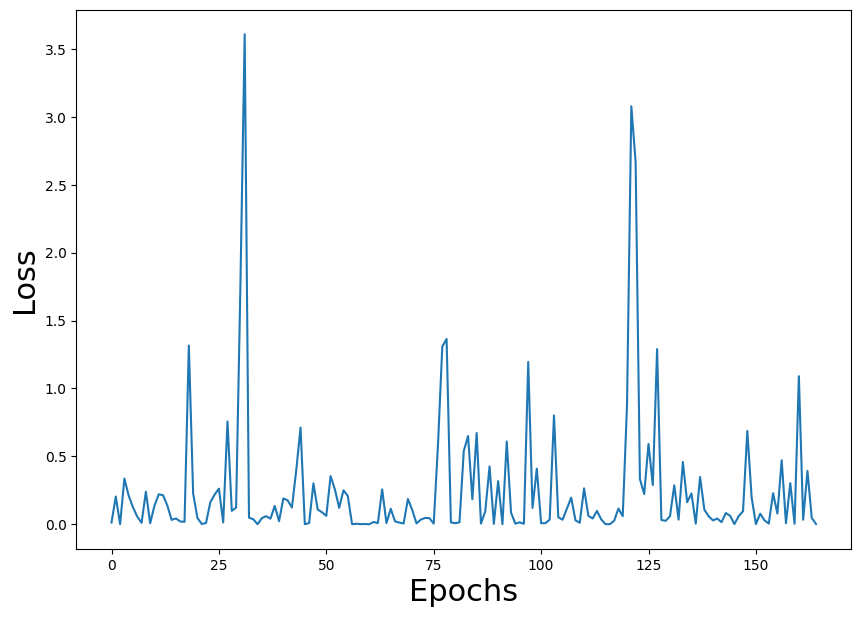

In [17]:
plt.figure(figsize=(10,7))
plt.plot(df["Loss"])
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2383,  0.2369,  0.1339,  ..., -0.1234, -0.2279, -0.0471],
         [-0.1912,  0.0037,  0.0175,  ..., -0.1194, -0.0980,  0.1353],
         [-0.1708,  0.0710, -0.1172,  ..., -0.1225, -0.2134, -0.1451],
         ...,
         [-0.1096,  0.0052,  0.2216,  ...,  0.3223,  0.2396,  0.3302],
         [ 0.2922,  0.0415,  0.3373,  ..., -0.1883, -0.2760, -0.1563],
         [-0.1166, -0.1205, -0.0829,  ...,  0.1823, -0.0312, -0.0604]],
        requires_grad=True),
 Parameter containing:
 tensor([-9.8357e-02, -6.1091e-02, -5.0666e-02, -4.4097e-02,  1.5473e-01,
         -1.5683e-01,  1.6600e-01, -5.2379e-02,  1.5804e-01, -1.7453e-02,
         -1.5397e-01,  1.5279e-01, -5.1785e-02, -1.5161e-01, -1.8917e-01,
         -2.4576e-01, -7.3855e-02,  1.8401e-03, -1.3261e-01, -1.7798e-01,
         -5.8833e-02,  1.4871e-01, -1.5142e-01,  1.1912e-01, -5.5328e-02,
          1.1369e-01, -1.3062e-01,  1.6211e-01, -3.2060e-03,  1.1938e-01,
          7.3064e-02, -1.8276e-01,  2.14